# Face Recognition

**IMPORTANT:** Download and unzip model from the following link: https://drive.google.com/file/d/1CL_kYhzRGCtQHAdKB-XyXoGRYS2zqALj/view?usp=sharing

One possible application of a CNN or Computer Vision in general is the face recognition. In face recognition we want to identify a person from a database of $K$ persons, i.e. we want a single input image to map to the ID of one of the $K$ persons in the database (or no output if the person was not recognized). This is different from face verification where we compare the input image only to a single persona and verify whether the input image is that of the claimed person.

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" For example, this video shows a face recognition video of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.

<video controls src="videos/Face Recognition demo.mp4" height="300px"></video>

## One-shot Learning

We want to train a model that is able to recognize faces. The typical example here is that you're building a facial recognition system for the employees of a company and usually HR only has one picture for each employee. This is called a **One-shot Learning** problem. This is in contrast with tyical machine learning problem where a model learngs from hundreds or thousands of examples of a particular class. Conventional CNNs are not suitable for this kind of task, because not only we will not have enough data to train it, but also the whole network would have to be re-trained if we want ro identify a new person.

### Usual Approach
a way to implement face recognition with CNN can be as in the figure below. We train a CNN on our database of images (our 5 employees) and use a softmax unit at the end with 6 outputs (1 for each employee and 1 for the option 'none of them').

<figure>
<img src="images/usual approach.png" width="500px">
</figure>

Issues with the implementation above for the given problem:
- would not work well for a small training set
- would need retraining when we need to recognize new persons, right ? Because our output layer learned to predict a fixed number of classes. New class, new training.

### Better alternative: Similarity Function
To fix this issue, when we perform face recognition we apply a **similarity function** $d(x^{(i)}, x^{(j)})$ that is able to calculate the similarity between two images of person $x^{(i)}$ and person $x^{(j)}$ as value $\tau \text{(degree of difference)}$. For the same person or look alikes $\tau$ will be small and larger for different persons.

$$
d(x^{(i)}, x^{(j)}) =

\begin{cases}
    \leq \tau \ \text{"same"} \\
    > \tau  \ \text{"different"}
\end{cases}
$$

## Siamese networks

To compute the degree of difference, we could compare pixel by pixel. But this would not give the best results when we deal with different pose, different illumination etc for the same person.

<img src="images/pixel_comparison.png" width="500px">

A better way to implement this similarity function is a siamese network (<a href='https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf'>Taigman et al 2014</a>). This method uses two identical CNNs that compute **embeddings** - vector encodings of the input image.  The encoding of the input image is a vector of arbitrary dimensions (e.g. 128 components), where similar pictures lead to similar encodings. And afterwards it compares the **distance** between these embeddings.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

<img src="images/siamese-network-function.png">

The similarity function can then be implemented as the vector norm of two image vectors:

$$ d(x^{(i)}, x^{(j)}) = || f(x^{(i)}) - f(x^{(j)}) ||_2^2 $$

### Triplet Loss

A siamese network should calculate similar image vectors for similar images and different vectors for different images. In other words: the distance between image vectors should be small for similar images and big for dissimilar images. We need to train the siamese network to exhibit this property. To do this we can use the triplet loss function (TLF). When using the TLF we define the image of one specific Person as anchor image $A$ and compare it with another image of the same person (positive image $P$) and an image of a different person (negative image $N$). 

The triplets of images $(A, P, N)$:

- A is an "Anchor" image--a picture of a person.
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

Because of the initially formulated condition the following equation needs to hold true:

$$ d(A, P) = || f(A) - f(P) ||_2^2 \leq || f(A) - f(N) ||_2^2 = d(A, N)$$

We can rearrange this equation and get:

$$ || f(A) - f(P) ||_2^2 - || f(A) - f(N) ||_2^2 \leq 0$$

However, there a catch with this equation: We could achieve it to be true by simply “calculating” the zero vector for each image! To prevent this, we add a parameter α and get:

$$ || f(A) - f(P) ||_2^2 - || f(A) - f(N) ||_2^2 + \alpha \leq 0$$

The parameter $α$ is also called margin. The effect of this margin is that the value of $\tau$ for pictures of the same person differs a lot from pictures of different persons (i.e. d(A,P) is separated from d(A,N) by a big margin).

<img src="images/triplet loss.png" height="500px">

Check this real-life example:

<img src="images/tlf-distance-matrix.png" height="300px">

Considering all the points mentioned above we can define the TLF as follows:

$$ \mathcal{L}(A,P,N) = max(|| f(A) - f(P) ||_2^2 - || f(A) - f(N) ||_2^2 + \alpha, 0)$$

Maximizing the two values prevents the network from calculating negative losses. The total cost can be calculated as usuall by summing the losses over all triplets:

$$ J = \sum^{m}_{i=1} \mathcal{L}(A^{(i)},P^{(i)},N^{(i)})$$

When training the network, we try to find triplet images that are hard to train on, i.e., we find people that look a like and make the model find embeddings that are different by a big margin for these look-alikes.

# Face Recognition System
We're going to build a face recognition system for an office building where the building manager would like to offer facial recognition to allow the employees to enter the building. Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf). For more references [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf).


The complete Face Recognition system can be divided into three categories :

1. Face Detection

2. Feature extraction

3. Feature Matching

Basically, the output of one method is taken as an input for the next method.

<img src="images/system flow.webp">

**Channels-last notation**

We'll be using a pre-trained model which represents ConvNet activations using a "channels last" convention.

In other words, a batch of images will be of shape $(m, n_H, n_W, n_C)$.

## Packages

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
from os import listdir
from mtcnn.mtcnn import MTCNN
from keras_facenet import inception_resnet_v1
import numpy as np

from tensorflow import keras as k
k.backend.set_image_data_format('channels_last')



## Loading the Pre-trained Model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, you won't train it from scratch here. Instead, you'll load a previously trained model in the following cell; which might take a couple of minutes to run.

In [2]:
def load_facenet():
    model = inception_resnet_v1.InceptionResNetV1(
        input_shape=(160, 160, 3),
        classes=128,
    )
    model.load_weights('keras-facenet-h5/model.h5')
    return model

In [3]:
model = load_facenet()
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'normalize')>]


## Face Detection

The Face detection method is used to find the faces present in the image, extract the faces and use it in the recognition system. Face recognition algorithms typically work better when the input images contain only the faces of interest. When there are other objects or background elements present in the image, they can introduce noise and potentially confuse the algorithm.

<img src="images/mtcnn.webp">

For this task we will use a CNN called MTCNN

In [4]:
def extract_image(image_path, detector: MTCNN):
    """
    Extracts detected face for the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    img = Image.open(image_path)
    img = img.convert('RGB')
    pixels = asarray(img)
    face = detector.detect_faces(pixels)
    
    # get the x, y, width, and hight of the face in the image
    x1, y1, w, h = face[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2 = x1 + w
    y2 = y1 + h
    
    # locate the face on the image
    store_face = pixels[y1:y2, x1:x2]
    plt.figure()
    plt.imshow(store_face)
    face_img = Image.fromarray(store_face, 'RGB')
    face_img = face_img.resize((160, 160)) # Resize so it can be used with FaceNet
    return asarray(face_img)
    

## Create database

1. Import employee pics from filesystem
2. Detect and Extract faces
3. Embed images
4. Save to database

In [2]:
def load_faces(directory, detector):
    """
    Loads faces for a specific class (person) in a directory
    
    Arguments:
        directory -- directory to look for images in
        detector -- MTCNN face exctraction model
    
    Returns:
        list of faces
    """
    faces = []
    for filename in listdir(directory):
        file_path = directory + filename
        face = extract_image(file_path, detector)
        faces.append(face)
    return faces

In [6]:
def load_dataset(directory, detector):
    """
    Loads faces dataset from a directory
    
    Arguments:
        directory -- directory to look for images in
        detector -- MTCNN face exctraction model
    
    Returns:
        x -- list of faces
        y -- list of labels for each face
    """
    
    x, y = [], []
    for subdir in listdir(directory):
        path = directory + subdir +'/'
        faces = load_faces(path, detector)
        labels = [subdir for _ in range(len(faces))]
        print(f'There are {len(faces)} images in the class {subdir}')
        x.extend(faces)
        y.extend(labels)
    return asarray(x), asarray(y)

In [7]:
def extract_embedding(model, face_image):
    """
    Loads faces dataset from a directory
    
    Arguments:
        directory -- directory to look for images in
        detector -- MTCNN face exctraction model
    
    Returns:
        x -- list of faces
        y -- list of labels for each face
    """
    img = np.around(np.array(face_image) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

Now we will build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding, we have to first load the images which will also extract the face. Then we will extract the embeddings using the model, we do this by running the forward propagation of the model on the specified image.

We will use a python dictionary to simulate the database. This database will map each person's name to a 128-dimensional encoding of their face.

1/1 [==============================] - 0s 280ms/step
There are 1 images in the class Agatha Christie
1/1 [==============================] - 0s 47ms/step
There are 1 images in the class Christopher Nolan
1/1 [==============================] - 0s 48ms/step
There are 1 images in the class Garry Kasparov
1/1 [==============================] - 0s 40ms/step
There are 1 images in the class J.K. Rowling
1/1 [==============================] - 0s 41ms/step
There are 1 images in the class LeBron James
1/1 [==============================] - 0s 40ms/step
There are 1 images in the class Leonardo DiCaprio
1/1 [==============================] - 0s 39ms/step
There are 1 images in the class Miyazaki


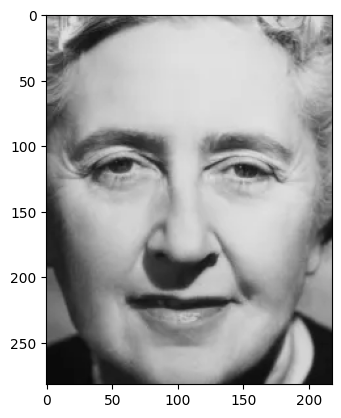

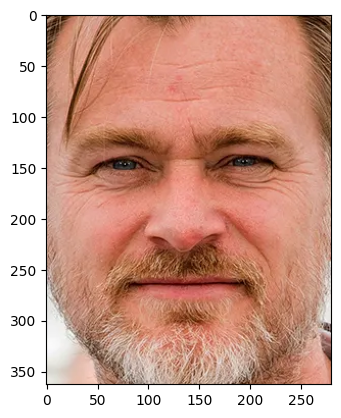

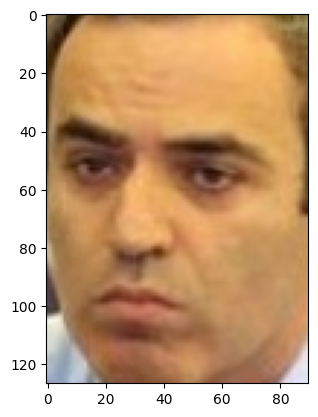

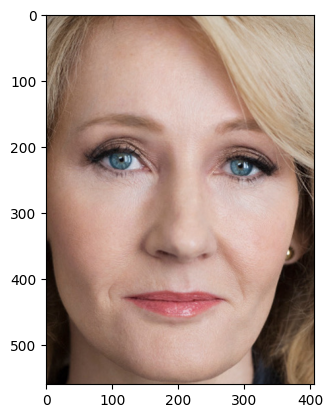

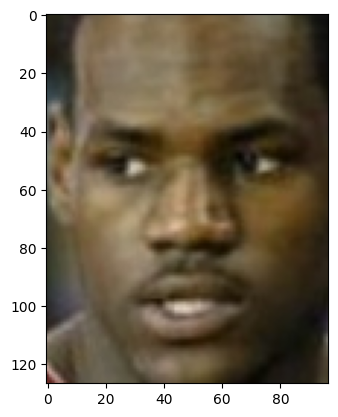

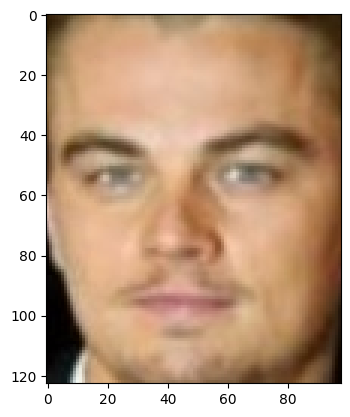

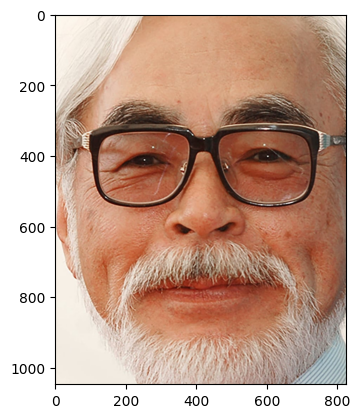

In [8]:
detector = MTCNN()
x, y = load_dataset('dataset/', detector)
database = {}
for idx, face in enumerate(x):
    database[y[idx]] = extract_embedding(model, face)


## Face Recognition

In [9]:
def who_is_it(image_path, database, model, detector):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    
    ## Step 1: Compute the target "encoding" for the image. Use 
    face_image = extract_image(image_path, detector)
    new_encoding =  extract_embedding(model, face_image)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100
    min_dist = 1000
    
    # Loop over the database dictionary's names and encodings.
    for (name, encoding) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(new_encoding - encoding, ord=2)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Person not found in the database, doors will not be opened")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist)+", doors are open now !!")

1/1 [==============================] - 0s 28ms/step
it's Agatha Christie, the distance is 0.5840823, doors are open now !!


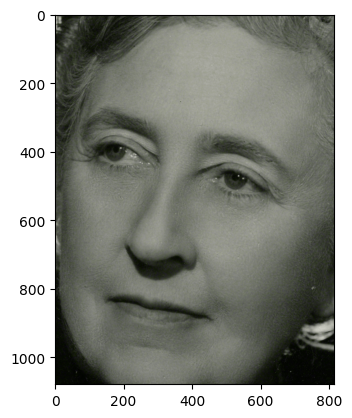

In [10]:
who_is_it('images/agatha_christie_2.png', database, model, detector)

1/1 [==============================] - 0s 39ms/step
it's Christopher Nolan, the distance is 0.49883264, doors are open now !!


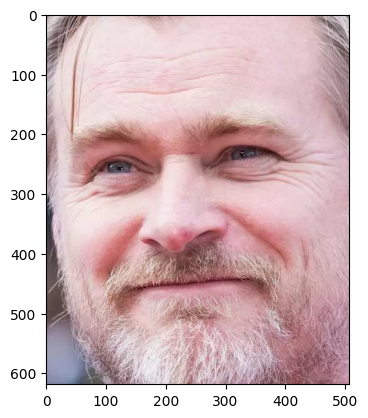

In [11]:
who_is_it('images/christopher-nolan-1.webp', database, model, detector)


1/1 [==============================] - 0s 35ms/step
Person not found in the database, doors will not be opened


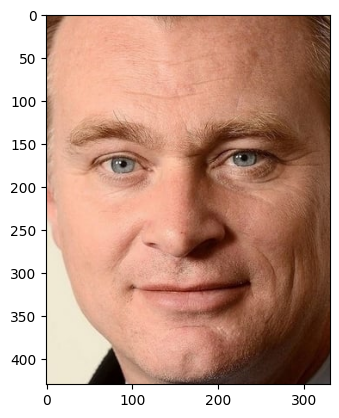

In [12]:
who_is_it('images/christopher_nolan_2.jpg', database, model, detector)


1/1 [==============================] - 0s 59ms/step
it's Garry Kasparov, the distance is 0.56444085, doors are open now !!


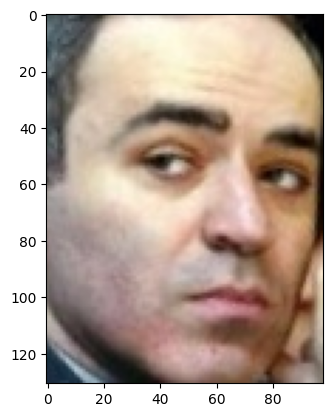

In [13]:
who_is_it('images/Garry_Kasparov_2.jpg', database, model, detector)


1/1 [==============================] - 0s 54ms/step
it's J.K. Rowling, the distance is 0.64520353, doors are open now !!


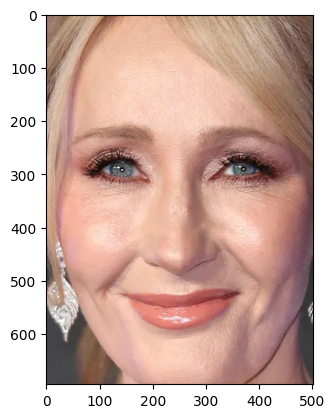

In [14]:
who_is_it('images/jkrowling_2.webp', database, model, detector)


1/1 [==============================] - 0s 31ms/step
it's LeBron James, the distance is 0.63612735, doors are open now !!


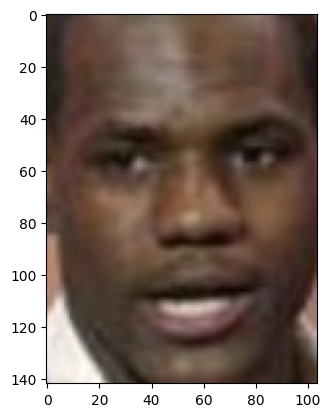

In [15]:
who_is_it('images/LeBron_James_2.jpg', database, model, detector)


1/1 [==============================] - 0s 74ms/step
it's Leonardo DiCaprio, the distance is 0.4549393, doors are open now !!


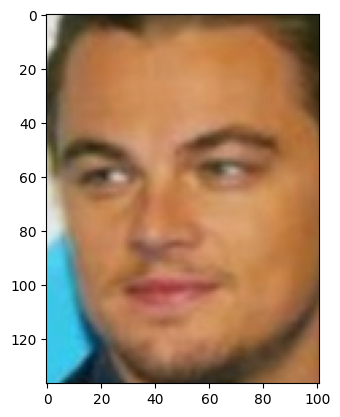

In [16]:
who_is_it('images/Leonardo_DiCaprio_2.jpg',database, model, detector)


1/1 [==============================] - 0s 75ms/step
it's Miyazaki, the distance is 0.6967421, doors are open now !!


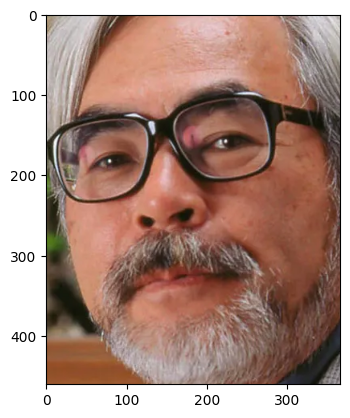

In [17]:
who_is_it('images/miyazaki_2.webp', database, model, detector)

## Testing

Now Morgan Freeman wants to enter the building, let's see if the system will allow him in

1/1 [==============================] - 0s 68ms/step
Person not found in the database, doors will not be opened


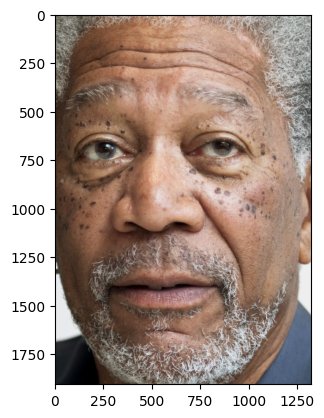

In [18]:
who_is_it('images/morgan freeman.jpg', database, model, detector)
